In [1]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

df = pd.read_csv('loan_approval_dataset_normalized.csv')
# delete the last row
df = df.drop(df.index[-1])
# suffle the data
df = df.sample(frac=1, random_state=12).reset_index(drop=True)

X = df.drop(['loan_status'], axis=1)
Y = df['loan_status']

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=1 - train_ratio,
    random_state=12,
)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=test_ratio / (test_ratio + validation_ratio),
    random_state=12,
)

In [3]:
num_rows, num_columns = x_train.shape

# Print the size
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 3201
Number of columns: 11


In [4]:
class Net(nn.Module):
    def __init__(self, D_in, H=128, D_out=1):
        super().__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, 32)
        self.fc3 = nn.Linear(32, D_out)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x) 
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

In [5]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y

In [6]:
import matplotlib.pyplot as plt
import numpy as np
lr_range = np.arange(0.001,0.1,0.001) # Learning rate range
num_epochs = 1 # Number of training epochs for each LR

# Lists to store learning rates and losses
learning_rates = []
losses = []
batch_size = 43
train_dataset = CustomDataset(x_train.values, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# LR range test loop
for lr in lr_range:
    test_model = Net(D_in=x_train.shape[1]).to(device)
    optimizer = optim.Adam(test_model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = test_model(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Record learning rate and final loss
    learning_rates.append(lr)
    losses.append(loss.item())
    

Optimal LR: 0.043000000000000003


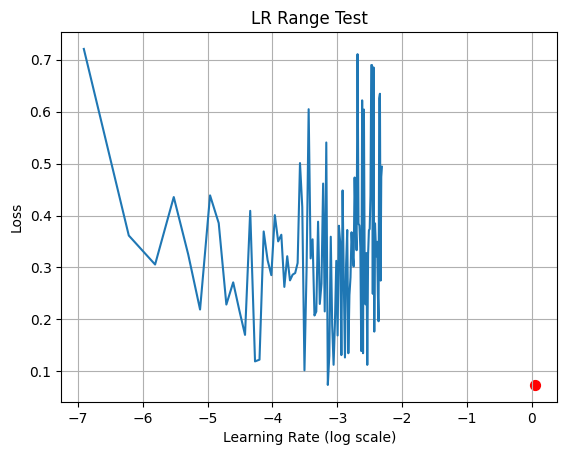

In [7]:
optimal_lr = learning_rates[np.argmin(losses)]
print(f"Optimal LR: {optimal_lr}")

# Plot the LR vs. Loss curve
plt.plot(np.log(learning_rates), losses)
plt.scatter(learning_rates[np.argmin(losses)], losses[np.argmin(losses)], color='red', label=f'Index {np.argmin(losses)}', s=50)

plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.grid(True)
plt.show()

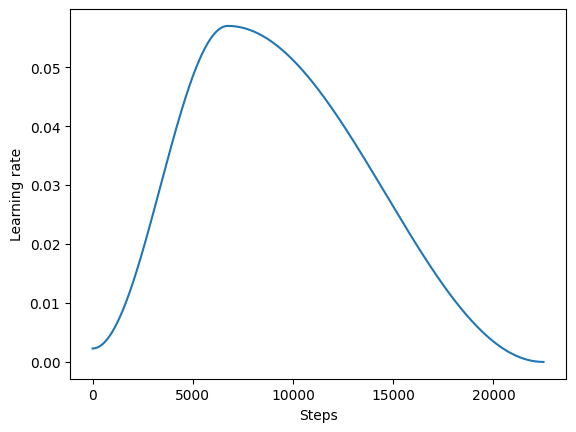

In [8]:
import matplotlib.pyplot as plt
model = Net(D_in=x_train.shape[1]).to(device)

num_epochs = 300
lr = 0.0057
batch_size = 43
steps = []
lrs = []

train_dataset = CustomDataset(x_train.values, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = OneCycleLR(optimizer, max_lr=lr*10, steps_per_epoch=len(train_loader), epochs=num_epochs, anneal_strategy='cos')

for epoch in range(num_epochs):
    for batch in range(len(train_loader)):
        optimizer.step() 
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * len(train_loader) + batch)

plt.plot(steps, lrs, label='OneCycle')
plt.xlabel('Steps') 
plt.ylabel('Learning rate')
plt.show()

In [9]:
model = Net(D_in=x_train.shape[1]).to(device)

num_epochs = 300
lr = 0.0057
batch_size = 43

train_dataset = CustomDataset(x_train.values, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(x_val.values, y_val.values)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = OneCycleLR(optimizer, max_lr=lr*10, steps_per_epoch=len(train_loader), epochs=num_epochs, anneal_strategy='cos')

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)
     
        loss = criterion(outputs.squeeze(), labels.squeeze())  
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    # Print training loss for this epoch
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_loader)}")

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

    # Print validation loss for this epoch
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}")
        print('----------------------------------------------------------------------------------')


Epoch 100/300, Training Loss: 0.1466891411691904
Epoch 100/300, Validation Loss: 0.14106239999334017
----------------------------------------------------------------------------------
Epoch 200/300, Training Loss: 0.045627720380822814
Epoch 200/300, Validation Loss: 0.05858247762856384
----------------------------------------------------------------------------------
Epoch 300/300, Training Loss: 0.005668792490699464
Epoch 300/300, Validation Loss: 0.02573109031441163
----------------------------------------------------------------------------------


In [10]:
model.eval()
test_dataset = CustomDataset(x_test.values, y_test.values)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        test_loss += loss.item()

        # Calculate accuracy
        predicted_classes = (outputs >= 0.5).int()  # Convert probabilities to binary predictions
        correct_predictions += (predicted_classes == labels).sum().item()
        total_samples += len(labels)

# Print test loss and accuracy
print(f"Test Loss: {test_loss / len(test_loader)}")
print(f"Test Accuracy: {correct_predictions / total_samples * 100:.2f}%")

Test Loss: 0.28992916839215466
Test Accuracy: 98.83%


In [11]:
import pandas as pd

data = {
    'no_of_dependents': [0],
    'education': [0],
    'self_employed': [1],
    'income_annum': [0.414141],
    'loan_amount': [0.308861],
    'residential_assets_value': [0.4],
    'commercial_assets_value': [0.463333],
    'luxury_assets_value': [0.092784],
    'bank_asset_value': [0.113402],
    'loan_term': [0.224490],
    'cibil_score': [0.224490]
}

df = pd.DataFrame(data)

inputs = torch.tensor(df.values, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    outputs = model(inputs)

print(outputs.item())

9.868934207065905e-20


In [12]:
scripted_model = torch.jit.script(model)
torch.jit.save(scripted_model, 'scripted_model.pt')

In [13]:
# test the model for all 0 
data = {
    'no_of_dependents': [0],
    'education': [0],
    'self_employed': [1],
    'income_annum': [0.414141],
    'loan_amount': [0.1],
    'residential_assets_value': [0.4],
    'commercial_assets_value': [0.463333],
    'luxury_assets_value': [0.092784],
    'bank_asset_value': [0.113402],
    'loan_term': [0.224490],
    'cibil_score': [0.224490]
}

df = pd.DataFrame(data)


torch_model = torch.jit.load('scripted_model.pt').to(device)

df = torch.tensor(df.values, dtype=torch.float32).to(device)
torch_model.eval()

with torch.no_grad():
    outputs = torch_model(df)

print(outputs.item())

6.85645284152838e-22
